In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import cv2
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transform for the DataLoader used for visualization (with normalization)
transform_visualize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Download and load the CIFAR-10 dataset
dataset_path = './CIFAR10_data'
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

# You can adjust the batch size and other parameters as needed
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(dataset_path, train=True, download=True, transform=transform_visualize),
    batch_size=batch_size, shuffle=True)

100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import cv2

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 10
learning_rate = 0.001
epsilon = 0.03

# Transformations for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
])

# CIFAR-10 Dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# AlexNet Model for CIFAR-10
class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetCIFAR10, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# Initialize model, optimizer, loss
model = AlexNetCIFAR10().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

# DeepFool-like Attack
def deepfool_attack(images, model, epsilon):
    model.eval()
    perturbed_images = images.clone().detach().to(device).requires_grad_(True)

    outputs = model(perturbed_images)
    labels = torch.argmax(outputs, dim=1)

    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()

    perturbation = epsilon * perturbed_images.grad.data.sign()
    adv_images = perturbed_images + perturbation
    adv_images = torch.clamp(adv_images, 0, 1)

    return adv_images.detach()

# Directory to save perturbed images
perturbed_dir = "perturbed_images_cifar10_modified"
os.makedirs(perturbed_dir, exist_ok=True)

# Save perturbed images
print("Generating and saving perturbed images...")
image_index = 0
for batch_idx, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    adv_images = deepfool_attack(images, model, epsilon)

    for i in range(images.size(0)):
        adv_img_np = adv_images[i].cpu().numpy().transpose(1, 2, 0)
        adv_img_np = (adv_img_np * 255).astype(np.uint8)

        class_label = labels[i].item()
        class_dir = os.path.join(perturbed_dir, str(class_label))
        os.makedirs(class_dir, exist_ok=True)

        file_path = os.path.join(class_dir, f"perturbed_{image_index}.jpg")
        cv2.imwrite(file_path, cv2.cvtColor(adv_img_np, cv2.COLOR_RGB2BGR))
        image_index += 1

print("Perturbed image generation completed.")


100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s]


Generating and saving perturbed images...
Perturbed image generation completed.


In [3]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import googlenet, GoogLeNet_Weights

# Set random seed
random_seed = 42
torch.manual_seed(random_seed)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
perturbed_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset path
perturbed_dataset_path = "./perturbed_images_cifar10_modified/"
if not os.path.exists(perturbed_dataset_path):
    raise FileNotFoundError(f"Directory {perturbed_dataset_path} not found.")

# Define model
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):  # CIFAR-10
        super(GoogLeNet, self).__init__()
        self.model = googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize model
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    global_model = nn.DataParallel(GoogLeNet()).to(device)
else:
    global_model = GoogLeNet().to(device)

# FL params
num_clients = 4
fraction = 0.2
num_epochs = 17
learning_rate = 0.001

# Optimizer, scheduler
optimizer = optim.Adam(global_model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# Dataset split
full_dataset = ImageFolder(perturbed_dataset_path, transform=perturbed_transform)
num_train = int(len(full_dataset) * (1 - fraction))
num_test = len(full_dataset) - num_train
train_dataset, test_dataset = random_split(full_dataset, [num_train, num_test])

# Client datasets
train_indices = list(range(len(train_dataset)))
client_datasets = []
start = 0
for _ in range(num_clients):
    end = start + int(len(train_indices) / num_clients)
    indices = train_indices[start:end]
    subset = Subset(train_dataset, indices)
    client_datasets.append(subset)
    start = end

# Create folder to save models
os.makedirs("saved_models_cifar10", exist_ok=True)

# Define checkpoint and epoch save paths
checkpoint_path = "saved_models_cifar10/global_model_checkpoint.pth"
epoch_file_path = "saved_models_cifar10/last_epoch.txt"

# Local training
def train_local(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = 100.0 * total_correct / total
    return model.state_dict(), total_loss / len(train_loader), acc

# Aggregation
def aggregate(global_model, local_models):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack([local_models[i][key].float()
                                        for i in range(len(local_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    return global_model

# Logging
train_losses_plot = []
train_accuracies_plot = []
test_losses_plot = []
test_accuracies_plot = []

# Training loop
for epoch in range(num_epochs):
    local_models = []
    local_losses = []
    local_accuracies = []

    for client_data in client_datasets:
        loader = DataLoader(client_data, batch_size=32, shuffle=True)
        local_model = GoogLeNet().to(device)
        if torch.cuda.device_count() > 1:
            local_model = nn.DataParallel(local_model)

        local_model.load_state_dict(global_model.state_dict())
        local_opt = optim.Adam(local_model.parameters(), lr=learning_rate)
        local_scheduler = optim.lr_scheduler.StepLR(local_opt, step_size=30, gamma=0.1)

        local_weights, loss, acc = train_local(local_model, loader, local_opt, criterion, device)
        local_models.append(local_weights)
        local_losses.append(loss)
        local_accuracies.append(acc)

        local_scheduler.step()

    # Aggregate and update global model
    global_model = aggregate(global_model, local_models)

    # Evaluate on test set
    global_model.eval()
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    total_loss = 0.0
    total_correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = global_model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    test_acc = 100.0 * total_correct / total
    test_loss = total_loss / len(test_loader)

    # Save model
    model_path = f"saved_models_cifar10/global_model_epoch_{epoch+1}.pth"
    torch.save(global_model.state_dict(), model_path)

    # Log
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {sum(local_losses)/len(local_losses):.4f} | Train Acc: {sum(local_accuracies)/len(local_accuracies):.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%\n")

    train_losses_plot.append(sum(local_losses) / len(local_losses))
    train_accuracies_plot.append(sum(local_accuracies) / len(local_accuracies))
    test_losses_plot.append(test_loss)
    test_accuracies_plot.append(test_acc)

    # ========== SAVE CHECKPOINT ==========
    torch.save(global_model.state_dict(), checkpoint_path)
    with open(epoch_file_path, 'w') as f:
        f.write(str(epoch + 1))
    print(f"Checkpoint saved at epoch {epoch+1} ✅\n")







Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 166MB/s]


Epoch [1/17]
Train Loss: 1.0021 | Train Acc: 65.42%
Test Loss: 0.7638 | Test Acc: 76.52%

Checkpoint saved at epoch 1 ✅

Epoch [2/17]
Train Loss: 0.7599 | Train Acc: 73.86%
Test Loss: 0.4593 | Test Acc: 84.47%

Checkpoint saved at epoch 2 ✅

Epoch [3/17]
Train Loss: 0.6562 | Train Acc: 77.75%
Test Loss: 0.3968 | Test Acc: 86.47%

Checkpoint saved at epoch 3 ✅

Epoch [4/17]
Train Loss: 0.5797 | Train Acc: 80.21%
Test Loss: 0.3387 | Test Acc: 88.08%

Checkpoint saved at epoch 4 ✅

Epoch [5/17]
Train Loss: 0.5210 | Train Acc: 82.47%
Test Loss: 0.3081 | Test Acc: 89.09%

Checkpoint saved at epoch 5 ✅

Epoch [6/17]
Train Loss: 0.4772 | Train Acc: 83.84%
Test Loss: 0.2936 | Test Acc: 89.67%

Checkpoint saved at epoch 6 ✅

Epoch [7/17]
Train Loss: 0.4354 | Train Acc: 85.19%
Test Loss: 0.2907 | Test Acc: 89.88%

Checkpoint saved at epoch 7 ✅

Epoch [8/17]
Train Loss: 0.3963 | Train Acc: 86.40%
Test Loss: 0.2572 | Test Acc: 90.80%

Checkpoint saved at epoch 8 ✅

Epoch [9/17]
Train Loss: 0.3751 

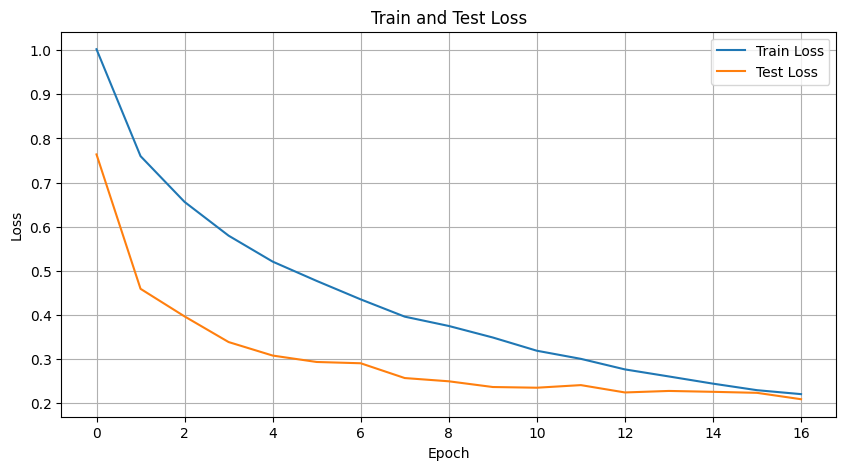

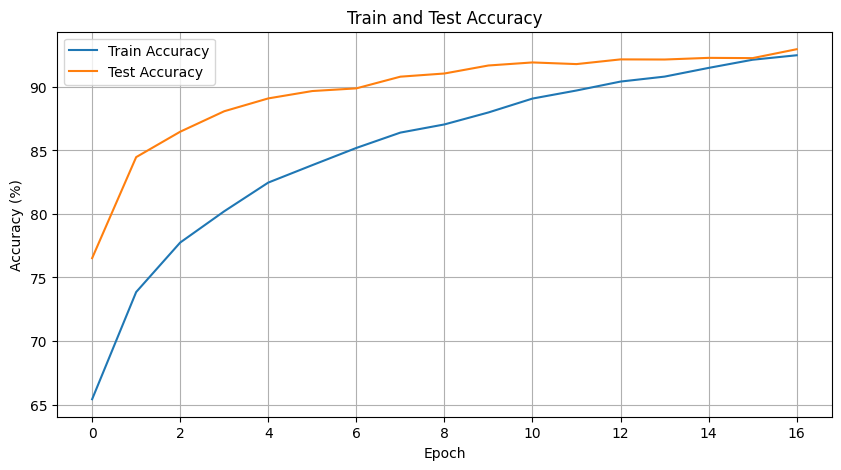

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_plot, label='Train Loss')
plt.plot(test_losses_plot, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies_plot, label='Train Accuracy')
plt.plot(test_accuracies_plot, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy')
plt.legend()
plt.grid()
plt.show()
